# Skip Gram

Step 1: Download files:
+ text8.zip

In [1]:
from urllib.request import urlretrieve
import os

data_dir = 'data'
url = 'http://mattmahoney.net/dc/text8.zip'
filename = url.split('/')[-1]
fullname = os.path.join(data_dir, filename)
if not os.path.exists(fullname):
    print('Downloading {} from {}...'.format(filename, url))
    urlretrieve(url, filename=fullname)
print('Downloading completed!')

Step 2: Import packages and define constants.

In [2]:
import numpy as np
import tensorflow as tf
import zipfile
import collections
import os
import math
import matplotlib.pyplot as plt

###############################################################################
# Constants
###############################################################################

fullname = "data/text8.zip"

vocab_size = 50000

batch_size = 128

embedding_size = 128

num_sampled = 64
learning_rate = 0.01
num_epochs = 100001
log_every = 10000

learning_rate = 1.0

valid_size = 20
valid_window = 100
top_k = 10

Step 3: Define dataset and create a dataloader.

In [3]:
'''
    Usage: Download text8.zip(http://mattmahoney.net/dc/text8.zip) and `python skip-gram.py`
    Training Dataset: 
        features: [batch_size] (indices)
        labels: [batch_size, 1] (indices)
    Graph: skip-gram.png
'''
###############################################################################
# Build dataset: generate_batch
###############################################################################
# read the text8.zip into a list of words
with zipfile.ZipFile(fullname) as f:
    tokens = (tf.compat.as_str(f.read(f.namelist()[0]))).split()

print(len(tokens))
print(tokens[0])

17005207
anarchism


In [4]:
def create_dictionary(tokens, vocab_size, special_tokens=['<unk>']):
    '''
        tokens: ['i', 'love', 'games', ...], i.e. a list of tokens
    '''
    count = collections.Counter(tokens).most_common(vocab_size - 1)
    
    # add special token like <unk>
    for special_token in special_tokens:
        freq = [[special_token, -1]]
        freq.extend(count)
    
    token2id = dict()
    for i in range(vocab_size):
        token2id[freq[i][0]] = i

    id2token = dict(zip(token2id.values(), token2id.keys()))

    indices = [] # tokens=>ids: ['i', 'love', 'games', ...] => [1222, 2332, 12, ...]
    for token in tokens:
        if token in token2id:
            indices.append(token2id[token])
        else:
            indices.append(0)
    
    return indices, token2id, id2token
    
indices, token2id, id2token = create_dictionary(tokens, vocab_size=vocab_size)


In [5]:
print('length of indices, token2id, id2token:', len(indices), len(token2id), len(id2token))
print('indices[0]:', indices[0])
print('token2id[\'apple\']:', token2id['apple'])
print('id2token[0]:', id2token[0])
print('id2token[1]:', id2token[1])
print('id2token[1221]:', id2token[1221])

length of indices, token2id, id2token: 17005207 50000 50000
indices[0]: 5234
token2id['apple']: 1221
id2token[0]: <unk>
id2token[1]: the
id2token[1221]: apple


In [6]:
data_index = 0

# define generate_batch function
def generate_batch(indices, batch_size ,skip_window=1, num_skips=2):
    '''
        window_size = skip_window * 2 + 1.
        example:
            Input: indices: [5234, 3081, 12, 6, 195]
            Output: X        y
                    3081    5234
                    3081    12
                    12      3081
                    12      6
                    6       12
                    6       195
            
    '''
    global data_index
    len_indices = len(indices)

    X = np.ndarray(shape=(batch_size,), dtype=np.int32)
    y = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    dq_len = skip_window * 2 + 1 # 3
    dq = collections.deque(maxlen=dq_len)
    for _ in range(dq_len):
        dq.append(indices[data_index])
        data_index = (data_index + 1) % len_indices

    sub = 0
    for _ in range(batch_size // num_skips):
        choices = [i for i in range(skip_window * 2 + 1)] # choices: [0, 1, 2]
        
        choices.pop(skip_window) # choices: [0, 2]
        while len(choices) != num_skips: # num_skips: 2
            choice = np.random.randint(0, len(choices))
            choices.pop(choice) # the argument of pop is the index

        for choice in choices: # choices: [0, 2]
            X[sub] = dq[skip_window]
            y[sub][0] = dq[choice]
            sub += 1

        # move the pointer
        dq.append(indices[data_index])
        data_index = (data_index + 1) % len_indices

    return X, y

Let's see what generate_batch does:

In [7]:
data_index = 0

x_batch, y_batch = generate_batch(indices, batch_size=16)
print(indices[:12])
for x_, y_ in zip(x_batch, y_batch):
    print(x_, y_)

data_index = 0 # adjust back

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156, 128, 742]
3081 [5234]
3081 [12]
12 [3081]
12 [6]
6 [12]
6 [195]
195 [6]
195 [2]
2 [195]
2 [3134]
3134 [2]
3134 [46]
46 [3134]
46 [59]
59 [46]
59 [156]


Step 4: Build the network
+ layer1: embedding
+ layer2: NCE loss

In [8]:
###############################################################################
# Construct a tensor graph: train + valid
###############################################################################
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('placeholder'):
        features = tf.placeholder(tf.int32, [batch_size], name='features') 
        labels = tf.placeholder(tf.int32, [batch_size,1], name='labels')


    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    
    embedded_chars = tf.nn.embedding_lookup(embedding, features) # [batch_size] => [batch_size, embedding_size]

    # define NCE loss
    with tf.name_scope("nce"):
        nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocab_size]))

        loss_op = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights, # [num_classes, embedding_size]
                                             biases = nce_biases, # [num_classes] 
                                             inputs = embedded_chars, # [batch_size, embedding_size]
                                             labels = labels, # [batch_size, num_true]; num_true means represents the number of positive samples
                                             num_sampled = num_sampled, # the number of negative samples
                                             num_classes = vocab_size)) # num_classes

    #train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_op)

    # 下面的代码是测试用的
    # randomly generate dataset designed to valid: [valid_size]
    valid_features = np.random.choice(valid_window, size=(valid_size,), replace=False)

    # define unitized embedding matrix
    def unitize_2d(vectors):
        return vectors / tf.sqrt(tf.reduce_sum(tf.square(vectors), axis=1, keepdims=True))

    unitized_embedding_op = unitize_2d(embedding)

    valid_embedded_chars = tf.nn.embedding_lookup(unitized_embedding_op, valid_features) # [valid_size] => [valid_size, embedding_size]

    # (valid_size, embedding_size) x (vocab_size, embedding_size)^T => (valid_size, vocab_size)
    final_embedding_op = tf.matmul(valid_embedded_chars, unitized_embedding_op, transpose_b=True)

Step 5: Train model and evaluate.

step 0 : loss = 286.32232666015625
step 10000 : loss = 48.316554895509135
step 20000 : loss = 29.367626234743753
step 30000 : loss = 21.793767386073092
step 40000 : loss = 17.75215796970617
step 50000 : loss = 15.243928160567954
step 60000 : loss = 13.548013787087125
step 70000 : loss = 12.304155184164028
step 80000 : loss = 11.368376541950692
step 90000 : loss = 10.633848328255075
step 100000 : loss = 10.037645585212639
Nearest to five: five four six seven eight three two zero nine kapoor 
Nearest to may: may can would could should will might must cannot kur 
Nearest to there: there they it he still she pontificia which these also 
Nearest to used: used known normality possible tamias fired methadone able kapoor agp 
Nearest to the: the its their kapoor his this thibetanus agouti microcebus michelob 
Nearest to most: most more many some use cl fricative hickok amar paymaster 
Nearest to so: so tabula frud if wished kapoor callithrix hbox too then 
Nearest to about: about six seven cal

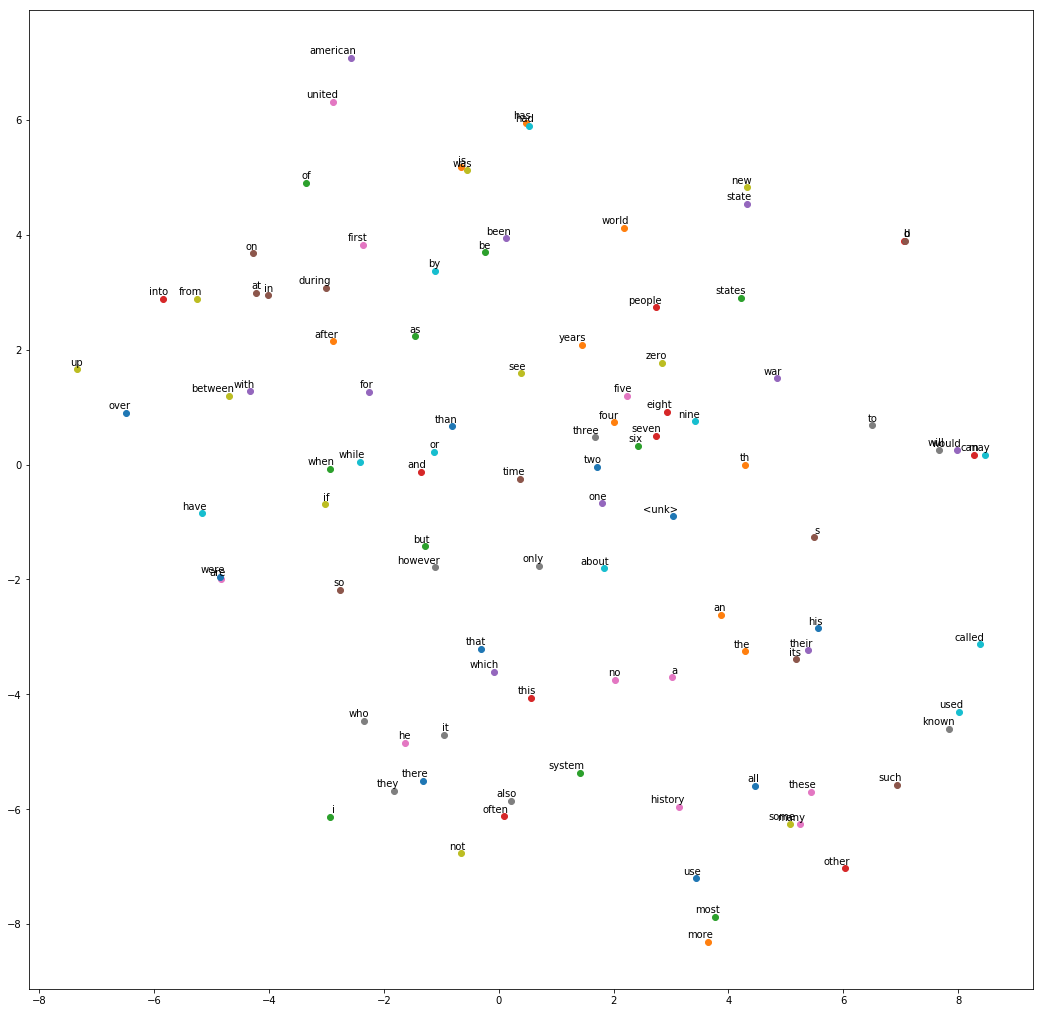

In [9]:
###############################################################################
# Train + valid(print)
###############################################################################
def eval():
    # get final embedding matrix
    final_embedding = sess.run(final_embedding_op)
   
    def check(words, labels):
        '''
            check for accuracy
            words: [valid_size, vocab_size]
            labels: [valid_size]. contains the indices of these words
        '''
        # sort the dim1 reversely
        res = []
        # pick out the first <top_k> for each word
        for word in words:
            res.append(((-word).argsort())[:top_k])

        # print dictionary[word] & dictionary[top_k_word]
        for i, label in enumerate(labels):
            print("Nearest to", id2token[label],end=': ')
            for j in range(top_k):
                print(id2token[res[i][j]], end=' ')
            print()
    # check for accuracy
    check(final_embedding, valid_features)

    # TSNE
    from sklearn.manifold import TSNE
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    unitized_embedding = sess.run(unitized_embedding_op)

    plot_only = 100
    low_dim_embs = tsne.fit_transform(unitized_embedding[:plot_only])

    # get indices, translate
    annotations = []
    for i in range(plot_only):
        annotations.append(id2token[i])
    
    # draw a graph that describes the embedding matrix
    def plot_with_labels(low_dim_embs, annotations):
        plt.figure(figsize=(18,18))
        for i, annotation in enumerate(annotations):
            x, y = low_dim_embs[i, :]
            plt.scatter(x, y)
            plt.annotate(annotation,
                         xy = (x, y),
                         xytext = (5, 2),
                         textcoords = 'offset points',
                         ha = 'right',
                         va = 'bottom')

        plt.show()

    plot_with_labels(low_dim_embs, annotations)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config, graph=graph) as sess:
    tf.global_variables_initializer().run()

    total_loss = 0.

    num_batches = len(indices) // batch_size
    
    for step in range(num_epochs):
        X, y = generate_batch(indices, batch_size)
        
        _, loss = sess.run([train, loss_op], feed_dict = {features:X, labels:y})

        total_loss += loss

        if step % log_every == 0:
            print("step", step, ": loss =" ,total_loss / (step + 1))
    eval()